In [200]:
#No course
import numpy as np
#import math
#import scipy
#import scipy.linalg  
#import time
#import scipy.sparse as sparse
#import scipy.sparse.linalg
import matplotlib
import matplotlib.pyplot as plt
#import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
#from pyDOE import lhs
import tensorflow as tf


#import tensorflow_probability as tfp

#Log: Implementing Eliptical PINN ADAM Aug 2023
#https://www.sciencedirect.com/science/article/pii/S0021999122003631?via%3Dihub


Burgers Equation

uy+uux= = 0, y positive

solution: u(x, y) = x/(1+y)

Eliptical Equation with Boundary Condition

u_yy+u_xx=0, x in [0,1], y in [0,1]



u(0,x) = sin(c  x)

u(1, x) = sin(c x)*exp(c)

u(y, 0) =0

u(y,1) = sin(c)exp(cy)

Exact Solution

u(x, y) = sin(c x)exp(c y)

uy = c sin(c x)exp(cy)

uyy = c^2 sin(c x) exp(c y)


ux = c cos(c x) exp(c y)

uxx = -c^2 sin(c x) exp(c y)


uxx+uyy = 0

In [201]:
#exact solution
def u_exact(data):
    output = tf.math.sin(const*data[:, 0])*tf.math.sin(const*data[:, 1])
    return output

In [202]:
#exact laplacian
def f_exact(data):
    output = -(2*const**2)*u_exact(data)
    return output

In [203]:
def p2t(x,y):
    #point to tensor for inputs
    xin = np.atleast_1d(x)
    yin = np.atleast_1d(y)
    output = tf.constant(np.array([xin,yin]).T, dtype=tf.float32)
    return output

In [204]:
def gen_whole_inputs(xmin, xmax, ymin, ymax, xnum, ynum):
    x = np.linspace(xmin, xmax, xnum)
    y = np.linspace(ymin, ymax, ynum)
    xv, yv = np.meshgrid(x, y)
    xv = np.concatenate(xv)
    yv = np.concatenate(yv)
    data = p2t(xv, yv)
    return data

In [205]:
def gen_bound_input(xmin, xmax, ymin, ymax, xnum, ynum):
    xline = np.linspace(xmin, xmax, xnum)
    yline = np.linspace(ymin, ymax, ynum)
    top = p2t(xline, np.ones(xnum)*ymax)
    bottom = p2t(xline, np.ones(xnum)*ymin)
    left = p2t(np.ones(ynum)*xmin, yline)
    right = p2t(np.ones(ynum)*xmax, yline)
    output = tf.concat([top, bottom, left, right], 0)
    output = tf.raw_ops.UniqueV2(x=output, axis = [0])[0]
    return output

In [206]:
def get_model():
        model=Sequential([Dense(width,activation='tanh',
                                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                input_shape=(2,),name='H1')])
        for i in range(depth):
            model.add(Dense(width,activation='tanh',name='H'+str(i+2)))
        model.add(Dense(1,name='output_layer'))
        return model

In [207]:
def u(model, data):
    output = model(data)
    return output[:, 0]

In [208]:
def f(model, data):
    with tf.GradientTape(persistent = True) as tp1:
        tp1.watch(data)
        with tf.GradientTape() as tp2:
            tp2.watch(data)
            sol = u(model, data)
        grad= tp2.gradient(sol, data)
        u_x = grad[:, 0]
        u_y = grad[:, 1]
    u_xx = tp1.gradient(u_x, data)[:, 0]
    u_yy = tp1.gradient(u_y, data)[:,1]
    output = u_xx+u_yy
    return output 

In [209]:
def ode_system(model, u_hat, bound_init, bddata, intdata, f_exact_int, u_hat_bound, pen_param, lag_mult): 
    PINN_loss = tf.reduce_mean(tf.math.square(f_exact_int-f(model, intdata)))
    MSE_loss = tf.reduce_mean(tf.math.square(u_hat_bound-u(model, bddata)))
    
    total_loss = PINN_loss+lag_mult*MSE_loss+0.5*pen_param*MSE_loss*MSE_loss
    lag_mult += pen_param*MSE_loss #update according to formula (13) of PECANN paper
    return total_loss, lag_mult

In [210]:
def train_model(model, u_hat, bound_init, bddata, intdata, max_it, pen_param, max_pen_param, lag_mult):
    loss_history = []
    f_exact_int = f_exact(intdata)
    u_hat_bound = u_hat(bound_init, bddata)
    for itr in range(max_it):
        with tf.GradientTape() as tape:
            (train_loss, lag_mult) = ode_system(model,u_hat, bound_init, bddata, intdata, f_exact_int, u_hat_bound, pen_param, lag_mult)
            grads = tape.gradient(train_loss, model.trainable_variables)
            optm.apply_gradients(zip(grads, model.trainable_variables))
        pen_param = min(2*pen_param, max_pen_param)

        if itr % 10 == 0:
            print(train_loss.numpy())
            loss_history.append(train_loss.numpy())
    return model, loss_history

In [211]:

def subdomain_locator(Nvm, Nvn, x, y):
    intx = x*Nvm
    inty = y*Nvn

    iintx=int(intx)
    iinty=int(inty)
    
    colnum= np.sign(intx-iintx)*1+iintx+1-abs(np.sign(intx))

    rownum= np.sign(inty-iinty)*1+iinty+1-abs(np.sign(inty))

    i = int(colnum-1+(rownum-1)*Nvm)
    #if i!=0:
    #    print(i, x, y, colnum, rownum)
    return i

In [212]:
def predictor(models, indata):
    output = np.zeros(len(indata[:,0]))
    for i in range(len(indata)):
        datax = indata[i, 0]
        datay = indata[i, 1]
        el = subdomain_locator(Nvm, Nvn, datax, datay)
        model = models[el]
        
        #input_data = np.vstack([datapoint, [0,0]])

        #input_data = tf.convert_to_tensor(input_data, np.float32)
        #tensorpoint = tf.Variable([datapoint], dtype=tf.float32)
        out = model(p2t(datax, datay))
        outarray = out.numpy()
        output[i] = outarray
        
        
        #output[i] = u_exact(datapoint) #for testing
    
        
        
   
    return output

In [213]:
def update_bounds(models, DomNum, sub_x_min, sub_x_max, sub_y_min, sub_y_max, sub_Nvm, sub_Nvn, top_bounds, bottom_bounds, left_bounds, right_bounds, bound_init):
    
    for i in range(DomNum):
        xline = np.linspace(sub_x_min[i], sub_x_max[i], sub_Nvm)
        yline = np.linspace(sub_y_min[i], sub_y_max[i], sub_Nvn)
        if sub_y_min[i] !=0:
            bottom_bounds[i, :] = predictor(models, p2t(xline, np.full(len(xline), sub_y_min[i])))
        if sub_y_max[i] !=1:
            top_bounds[i, :] = predictor(models, p2t(xline, np.full(len(xline), sub_y_max[i])))
        if sub_x_min[i] !=0:
            left_bounds[i, :] = predictor(models, p2t(np.full(len(yline), sub_x_min[i]), yline))
        if sub_x_max[i] !=1:
            right_bounds[i,:] = predictor(models, p2t(np.full(len(yline), sub_x_max[i]), yline))

    return (top_bounds, bottom_bounds, left_bounds, right_bounds)

In [214]:
def Eliptic_PINN(model, u_hat, bound_init, top_bounds, bottom_bounds, left_bounds, right_bounds, xmin, xmax, ymin, ymax, sub_Nvm, sub_Nvn, pen_param, max_pen_param, lag_mult):
    
    
    bound_data = gen_bound_input(xmin, xmax, ymin, ymax, sub_Nvm, sub_Nvm)
    whole_data = gen_whole_inputs(xmin, xmax, ymin, ymax, sub_Nvm, sub_Nvn)
    
    (model, sub_loss) = train_model(model,u_hat, bound_init, bound_data, whole_data, max_it, pen_param, max_pen_param, lag_mult)
    

    
    return model, sub_loss

In [215]:
def DeepDDM(Nvm,Nvn, h_x, h_y, epochs, sub_Nvm, sub_Nvn, bound_init, max_pen_param, pen_param_0, lag_mult_0):
    #Nvm = number of sub domains on x  axis
    #Nvn = number of sub domains  on y axis
        #1 on both means there is only the original domain
    
    #sub_Nvm = number of elements within subdomains on  x axis for use in the net training 
    #sub_Nvn = number of elements within subdomains on  y axis for use in the net training
        #1 on both means just corners would be used
    
    
    #Nvm*Nvn= number of subdomains
    #h is percentage of overlap in the relevant axis
        #note h_x<=1, h_y<=1
    #Space is [0,1] by [0,1]
    
    #connnectivity matrix, as in what subdomains are connected
    #is boundary matrix
    #range of the various subdomains
    
    len_x = 1/(Nvm) # length of the subdivisions on x axis
    len_y = 1/(Nvn) #length of the subdivisions on y axis
    global domain_loss
    global l2max
    l2max = []
    DomNum = Nvm*Nvn
    sub_x_min = np.empty(DomNum) 
    sub_x_max = np.empty(DomNum)
    sub_y_min = np.empty(DomNum)
    sub_y_max = np.empty(DomNum)
    el_rownum = np.empty(DomNum)
    el_colnum = np.empty(DomNum)
    
    if 0==Nvm-1:
        sub_x_max = np.ones(DomNum)
        sub_x_min = np.zeros(DomNum)
    else:
        for i in range(DomNum):
        #generates which row, column each element is in
            el_colnum[i] = np.mod(i,Nvm)
            if el_colnum[i] == 0:
                sub_x_max[i] = (el_colnum[i]+1+h_x)*len_x
                sub_x_min[i] = (el_colnum[i])*len_x
            elif el_colnum[i] == Nvm-1:
                sub_x_min[i] = (el_colnum[i]-h_x)*len_x
                sub_x_max[i] = (el_colnum[i]+1)*len_x
            else:
                sub_x_min[i] = (el_colnum[i]-h_x)*len_x
                sub_x_max[i] = (el_colnum[i]+1+h_x)*len_x

    if 0==Nvn-1:
        sub_y_max = np.ones(DomNum)
        sub_y_min = np.zeros(DomNum)
    else:
        for i in range(DomNum):
        #generates which row, column each element is in
            el_rownum[i] = int(i/Nvm) 

            if el_rownum[i]==0:
                sub_y_max[i] = (el_rownum[i]+1+h_y)*len_y
                sub_y_min[i] = el_rownum[i]*len_y
            elif el_rownum[i]==Nvn-1:
                sub_y_min[i] = (el_rownum[i]-h_y)*len_y
                sub_y_max[i] = (el_rownum[i]+1)*len_y
            else:
                sub_y_min[i] = (el_rownum[i]-h_y)*len_y
                sub_y_max[i] = (el_rownum[i]+1+h_y)*len_y

        
    u_pred = np.zeros([Nvm*sub_Nvm, Nvn*sub_Nvn])    
    top_bounds = np.zeros([DomNum , sub_Nvm])
    bottom_bounds = np.zeros([DomNum , sub_Nvm]) 
    left_bounds = np.zeros([DomNum, sub_Nvn]) 
    right_bounds = np.zeros([DomNum, sub_Nvn]) 
    
    models = [None]*DomNum
    dom_loss_history = np.zeros(epochs)
    
    #initialize boundaries
    xzeros = np.zeros(sub_Nvm)
    yzeros = np.zeros(sub_Nvn)
    xones = np.ones(sub_Nvm)
    yones = np.ones(sub_Nvn)
    for i in range(DomNum):
        xline = np.linspace(sub_x_min[i], sub_x_max[i], sub_Nvm)
        yline = np.linspace(sub_y_min[i], sub_y_max[i], sub_Nvn)
        
        if sub_y_min[i] ==0:
            bottom_bounds[i, :] = u_exact(p2t(xline, xzeros))
            #for j in range(sub_Nvm):
             #   bottom_bounds[i, j] = u_exact(p2t(xline[j], 0))
        else:
            bottom_bounds[i, :] = bound_init(p2t(xline, xzeros))
            #for j in range(sub_Nvm):
            #   bottom_bounds[i, j] = bound_init([xline[j], sub_y_min[i]])
        if sub_y_max[i] ==1:
            top_bounds[i, :] = u_exact(p2t(xline, xones))
            #for j in range(sub_Nvm):
            #    top_bounds[i,j] = u_exact(p2t(xline[j], 1))
        else:
            top_bounds[i, :] = bound_init(p2t(xline, xones))

            #for j in range(sub_Nvm):
                #top_bounds[i,j] = bound_init([xline[j], sub_y_max[i]])

        if sub_x_min[i]==0:
            left_bounds[i, :] = u_exact(p2t(yzeros, yline))
            #for j in range(sub_Nvn):
            #    left_bounds[i, j] =  u_exact(p2t(0, yline[j]))
        else:
            left_bounds[i, :] = bound_init(p2t(yzeros, yline))
            #for j in range(sub_Nvn):
            #   left_bounds[i, j] = bound_init([sub_x_min[i], yline[j]])
                
        if sub_x_max[i]==1:
            right_bounds[i, :] = u_exact(p2t(yones, yline))
            #for j in range(sub_Nvn):
            #    right_bounds[i, j] = u_exact(p2t(1, yline[j]))
        else:
            right_bounds[i, :] = bound_init(p2t(yones, yline))
            #for j in range(sub_Nvn):
            #    right_bounds[i, j] = bound_init([sub_x_max[i], yline[j]])
   
    #exact_l2 = f_exact(gen_whole_inputs(0, 1, 0, 1, 100, 100))
    error_history = np.zeros(epochs)
    #xl2 = np.linspace(0, 1, 100)
    #yl2 = np.linspace(0, 1, 100)

    #Xl2, Yl2 = np.meshgrid(xl2,yl2) 
    #Xl2_star=np.hstack((Xl2.flatten()[:,None],Yl2.flatten()[:,None]))
    
    
    def u_hat(bound_init, data):
        approx = bound_init(data)
        if type(approx) == np.ndarray:
            output = approx
        else:
            output = approx.numpy()
        for i in range(len(data)):
            if data[i, 0]==0 or data[i, 1]==0 or data[i, 1]==1 or data[i, 1]==1:
                output[i] = u_exact(tf.expand_dims(data[i, :], axis = 0))

        return output
    for i in range(DomNum):
        models[i] = get_model()
        
    tol_data = gen_bound_input(0, 1, 0, 1, 100, 100)

    flag=False
    epoch=0
    while epoch<epochs and flag==False: 
        if epoch ==1: #the second epoch, updates the initializer to be the predictor, so boundary info exchange happens
            def bound_init2(data):
                output= predictor(models, data)
                return output
            bound_init = bound_init2

        for i in range(DomNum):
            pen_param = pen_param_0
            lag_mult = lag_mult_0
            print("Epoch: "+str(epoch+1) +"  Subdomain: "+str(i+1))
            (update_model, loss_update) = Eliptic_PINN(models[i], u_hat,bound_init,  top_bounds[i, :], bottom_bounds[i, :], left_bounds[i, :], right_bounds[i, :], sub_x_min[i], sub_x_max[i], sub_y_min[i], sub_y_max[i], sub_Nvm, sub_Nvn, pen_param, max_pen_param, lag_mult)
            models[i] = update_model 
            
            dom_loss_history[epoch] = dom_loss_history[epoch]+loss_update[-1]
        #Xl2_star=np.hstack((Xl2.flatten()[:,None],Yl2.flatten()[:,None]))
        error_history[epoch] = get_l2(models)
        #update bounds with new guesses   
        
        if epoch==0:
            prev_net = predictor(models, tol_data)
            prev_norm = tf.reduce_mean(tf.math.square(prev_net))
        else:
            new_net = predictor(models, tol_data)
            net_diff = tf.reduce_mean(tf.math.square(prev_net -new_net))
            new_norm = tf.reduce_mean(tf.math.square(new_net))
            rel_net_diff = net_diff/min(new_norm, prev_norm)
            if rel_net_diff<net_tol:
                print("Network has converged")
                flag=True
            else:
                prev_net = new_net
                prev_norm = new_norm
                
        if error_history[epoch]<error_tol:
            flag = True
            print("Error is below tolerance.")
        epoch+=1
        
        (top_bounds, bottom_bounds, left_bounds, right_bounds)= update_bounds(models, DomNum, sub_x_min, sub_x_max, sub_y_min, sub_y_max, sub_Nvm, sub_Nvn, top_bounds, bottom_bounds, left_bounds, right_bounds, bound_init)
    
    dom_loss_history = dom_loss_history/(DomNum) #Averages over subdomains
    
    
    plt.figure()
    for i in range(DomNum):
        plt.vlines(x=[sub_x_min[i], sub_x_max[i]], ymin=0, ymax=1)
        plt.hlines(y=[sub_y_min[i], sub_y_max[i]], xmin=0, xmax=1)
    plt.show()
    
    plt.figure()
    plt.plot(dom_loss_history[np.nonzero(dom_loss_history)], label="Domain Loss")
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(error_history[np.nonzero(error_history)], label ="Relative L2 Error")
    plt.legend()
    plt.show()
    
    
    
    print("Loss "+str(dom_loss_history[np.nonzero(dom_loss_history)]))
    print("Error " +str(error_history[np.nonzero(error_history)]))
    np.savetxt("Loss_and_error_PECANN.txt", (dom_loss_history[np.nonzero(dom_loss_history)], error_history[np.nonzero(error_history)]), delimiter =", ", header= "Loss, Error")

    
    return models
    
    
        
        
            
            
    

In [216]:
def get_l2(models):
    data = gen_whole_inputs(0,1, 0,1, 100, 100)
    pred = predictor(models, data)
    exact = u_exact(data)
    #pred = pred.reshape([100, 100])
    error = np.linalg.norm(exact-pred)/np.linalg.norm(exact)
    return error


In [217]:
def plotter(models):
    data = gen_whole_inputs(0, 1, 0, 1, 100, 100)
    approx = predictor(models, data)
    exact = u_exact(data).numpy()
    abs_error = abs(exact - approx)
    MAE_error = (abs_error).mean()
    print("Mean Absolute Error: " + str(MAE_error))
    rel_L2_err = np.linalg.norm(exact-approx)/np.linalg.norm(exact) 
    print("Relative L2 Error: " + str(rel_L2_err))
    print("Error Max "+ str(abs_error.max()))
    print("Error Min "+ str(abs_error.min()))
    x = data[:, 0].numpy()
    y = data[:, 1].numpy()
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 1, 1)
    plt.tricontourf(x, y, abs_error ,100)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label = "Absolute Error")
    #plt.plot()
    
    plt.subplot(3, 1, 2)
    plt.tricontourf(x, y, approx ,100)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label = "Predicted")
    
    plt.subplot(3, 1, 3)
    plt.tricontourf(x, y, exact ,100)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label = "Exact")
    
    np.savetxt("Approx_PECANN.txt", approx)
    np.savetxt("Exact_PECANN.txt", exact)



    
    return 

In [218]:
def xsplice_plt(models, x):
    y = np.linspace(0, 1, 100) 
    data= p2t(np.full(100, x), y)
    exact = u_exact(data)
    
    plt.plot(exact, label = "X = "+str(x))
    plt.plot(predictor(models, data), label = "X Approx")
    plt.legend()
    plt.show()


In [219]:
def ysplice_plt(models, y):
    x = np.linspace(0, 1, 100) 

    data = p2t( x, np.full(100, y))


    plt.plot(u_exact(data), label = "Y = "+str(y))
    plt.plot(predictor(models, data), label = "Y Approx")
    plt.legend()
    plt.show()

In [220]:
def zero_init(data):
    return np.zeros(len(data))
#for exact initializer put u_exact as the initializer
#def random_init(data):
#    return np.random.rand(len(data))
def avg_init(x, y):
    avg = 0.25*((1-x)*u_exact([x, 0])+x*u_exact([x, 1])+(1-y)*u_exact([0, y])+y*u_exact([1, y]))
    return avg
#def noisy_init(data):
 #   return u_exact(data)+noise*random_init(data)

In [221]:
Nvm = 2 #number of subintervals along x axis
Nvn = 2 #number of subintervals along y axis
h_x = 0.2 #percentage of overlap (<=1)
h_y = 0.2 #percentage of overlap (<=1)
epochs = 100
sub_Nvm = 100 #mesh for PINN training
sub_Nvn = 100
max_it = 100 #max_it for PINN training
initializer = zero_init #u_exact, zero_init, random_init, avg_init, noisy_init
global noise
noise = 0.05 #only for noisy initializer
#reset_models_betweeen_epochs = True
optm = tf.keras.optimizers.legacy.Adam(amsgrad=True)
net_tol= 1e-3 #tolerance for network convergeance 
error_tol = 0.1 #tolerance for error


pen_param = 1 #initial penalty parameter
max_pen_param  = 10000 #safeguarding penalty parameter
lag_mult = 1 #initial param for the MSE_loss term

global per_collocation
global per_interior
global width #width in NN models
global depth #depth in NN models
global const #PDE constant
global int_weight #weight for interior loss, between 0 and 1, higher means more weight on PDE loss than boundary loss
int_weight = 0.5
const = 3.141592653589793 #math.pi
per_collocation = 0.5
per_interior = 0.5
width  = 20
depth  = 6

Epoch: 1  Subdomain: 1
162.2785
128.40512
148.12027
135.24493
129.77536
127.414665
125.70795
123.73012
120.90434
115.35995
Epoch: 1  Subdomain: 2
138.19582
160.19072
135.4159
100.71217
80.88844
81.40713
79.23658
77.97024
77.184074
76.38721
Epoch: 1  Subdomain: 3
124.847115
245.2435
148.79294
127.27623
124.21908
119.07323
111.21522
90.42556
70.67772
70.04481
Epoch: 1  Subdomain: 4
128.0881
141.65424
98.37194
87.26995
80.48611
75.92789
73.16565
72.557365
72.63805
72.66132
Epoch: 2  Subdomain: 1
102.49287
109.1937
86.388405
71.80072
63.48489
56.09875
48.512817
41.65196
35.198807
29.517948
Epoch: 2  Subdomain: 2
60.918255
45.95202
87.97986
92.645454
82.268265
63.32917
43.23806
35.072678
29.237076
27.30784
Epoch: 2  Subdomain: 3
57.637157
61.206047
118.62832
112.97915
105.07401
75.026924
57.103054
52.608765
49.194065
48.66222
Epoch: 2  Subdomain: 4
53.950115
64.84909
94.16259
65.94131
51.68493
43.371475
34.887836
29.63763
25.629883
20.692291
Epoch: 3  Subdomain: 1
11.655964
5.45319
14.00982

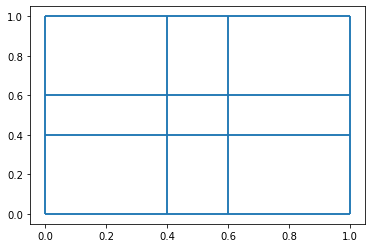

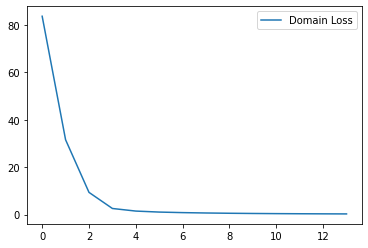

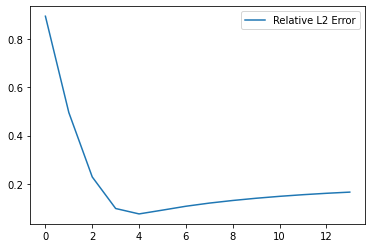

Loss [83.6133213  31.54507494  9.35730684  2.56935975  1.47689103  1.05581182
  0.82743289  0.66982807  0.55399419  0.46720541  0.40145941  0.35086463
  0.31132023  0.27983184]
Error [0.89396268 0.49512169 0.22851364 0.09775776 0.07536323 0.09106206
 0.10711755 0.12015421 0.13097398 0.14022751 0.14815348 0.15495893
 0.16074227 0.16563253]


In [222]:
tf.random.set_seed(1234)
models = DeepDDM(Nvm, Nvn, h_x, h_y, epochs, sub_Nvm, sub_Nvn, initializer, max_pen_param, pen_param, lag_mult)

Mean Absolute Error: 0.06006911415675153
Relative L2 Error: 0.16563253807495604
Error Max 0.29117867098293715
Error Min 6.0461461544036865e-06


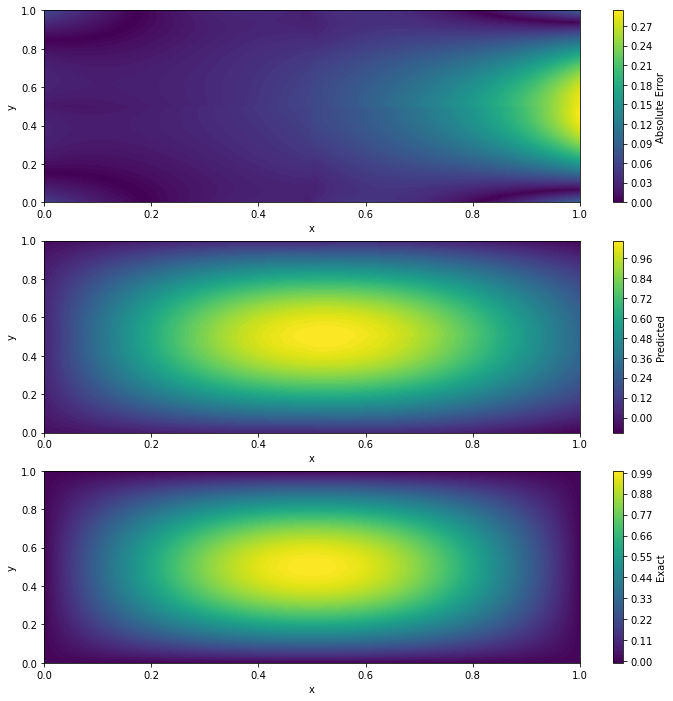

In [223]:
plotter(models)

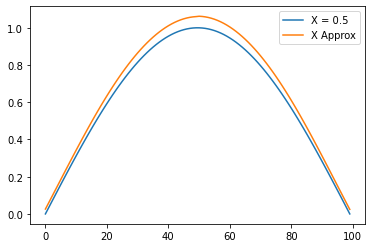

In [224]:
xsplice_plt(models, 0.5)

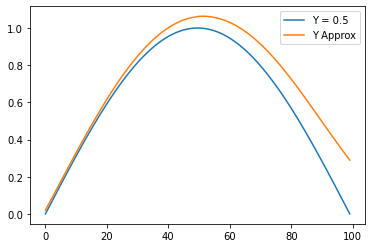

In [225]:
ysplice_plt(models, 0.50)